In [1]:
df = pd.read_csv("../unit3data.csv")

In [9]:
df

,timestamp,morbidostat_unit,od_reading_v,experiment,angle
0,2020-09-22T17:12:57.435Z,3,0.014360,Trial-7-76a6004d962741a1819c39098edd77b9,90
1,2020-09-22T17:12:57.466Z,3,0.182693,Trial-7-76a6004d962741a1819c39098edd77b9,135
2,2020-09-22T17:13:02.728Z,3,0.014336,Trial-7-76a6004d962741a1819c39098edd77b9,90
3,2020-09-22T17:13:02.764Z,3,0.182459,Trial-7-76a6004d962741a1819c39098edd77b9,135
4,2020-09-22T17:13:07.433Z,3,0.014360,Trial-7-76a6004d962741a1819c39098edd77b9,90
...,...,...,...,...,...
39419,2020-09-23T20:38:47.450Z,3,0.451108,Trial-7-76a6004d962741a1819c39098edd77b9,135
39420,2020-09-23T20:38:52.410Z,3,0.037157,Trial-7-76a6004d962741a1819c39098edd77b9,90
39421,2020-09-23T20:38:52.447Z,3,0.450232,Trial-7-76a6004d962741a1819c39098edd77b9,135
39422,2020-09-23T20:38:57.523Z,3,0.037282,Trial-7-76a6004d962741a1819c39098edd77b9,90


In [10]:
paired_data = []

for i, (_, row) in enumerate(df.iterrows()):
    if i % 2 == 0:
        to_append = {'timestamp': None, '135': None, '90': None}
        to_append['timestamp'] = row['timestamp']
        to_append['90'] = row['od_reading_v']
        
    else:
        to_append['135'] = row['od_reading_v']
        paired_data.append(to_append)
    

In [15]:
df.shape

(39424, 5)

In [36]:
_135 = df.sort_values(["angle", "timestamp"]).iloc[int(39424/2):].reset_index(drop=True)
_135 = _135.rename(columns={'od_reading_v': '135'})
_135 = _135.rename(columns={'timestamp': 'ts'})


_90 = df.sort_values(["angle", "timestamp"]).iloc[:int(39424/2)].reset_index(drop=True)
_90 = _90.rename(columns={'od_reading_v': '90'})


In [43]:
df_ = pd.concat((_135, _90), axis=1)

In [44]:
df_['ts'] = pd.to_datetime(df_['ts'])
df__ = df_.set_index("ts")[['135', '90']]

<AxesSubplot:xlabel='ts'>

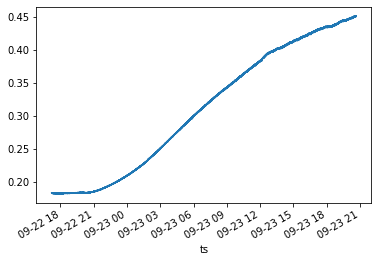

In [46]:
df__['135'].plot()

In [241]:
class ExtendedKalmanFilter:
    """
    Based on the algorithm in
    https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0181923#pone.0181923.s007

    The idea is that each sensor will evolve like:

    OD_{i, t+1} = OD_{i, t} * r_t

    for all i, t.

    This model is pretty naive (different sensors will behave / saturate differently).

    Example
    ---------

        initial_state = np.array([obs.iloc[0], 1.])
        initial_covariance = np.eye(2)
        process_noise_covariance = np.array([[0.00001, 0], [0, 1e-13]])
        observation_noise_covariance = 0.2
        ekf = ExtendedKalmanFilter(initial_state, initial_covariance, process_noise_covariance, observation_noise_covariance)

        ekf.update(...)
        ekf.state_

    """

    def __init__(self, initial_state, initial_covariance, process_noise_covariance, observation_noise_covariance):
        assert initial_state.shape[0] == initial_covariance.shape[0] == initial_covariance.shape[1]
        assert process_noise_covariance.shape == initial_covariance.shape
        #assert self._is_positive_definite(process_noise_covariance)
        #assert self._is_positive_definite(initial_covariance)
        #assert self._is_positive_definite(observation_noise_covariance)

        self._process_noise_covariance = process_noise_covariance
        self.observation_noise_covariance = observation_noise_covariance
        self.state_ = initial_state
        self.covariance_ = initial_covariance
        self.dim = self.state_.shape[0]

        self._OD_scale_counter = -1
        self._rate_scale_counter = -1

        self._original_process_noise_variance = np.diag(self._process_noise_covariance)[: (self.dim - 1)].copy()
        self._original_rate_noise_variance = self._process_noise_covariance[-1, -1]


    def predict(self):
        return (self._predict_state(self.state_, self.covariance_), self._predict_covariance(self.state_, self.covariance_))

    def update(self, observation):
        # TODO: incorporate delta_time
        assert observation.shape[0] + 1 == self.state_.shape[0]
        state_prediction, covariance_prediction = self.predict()
        residual_state = observation - state_prediction[:-1]
        H = self._jacobian_observation()
        residual_covariance = H @ covariance_prediction @ H.T + self.observation_noise_covariance
        kalman_gain = covariance_prediction @ H.T @ np.linalg.inv(residual_covariance)
        self.state_ = state_prediction + kalman_gain @ residual_state
        self.covariance_ = (np.eye(self.dim) - kalman_gain @ H) @ covariance_prediction
        return

    def scale_OD_variance_for_next_n_steps(self, factor, n):
        d = self.dim
        self._OD_scale_counter = n
        self._process_noise_covariance[np.arange(d - 1), np.arange(d - 1)] = factor * self._original_process_noise_variance

    def scale_rate_variance_for_next_n_steps(self, factor, n):
        d = self.dim
        self._rate_scale_counter = n
        self._process_noise_covariance[-1, -1] = factor * self._original_rate_noise_variance
        
        
    def process_noise_covariance(self):
        if self._OD_scale_counter == 0:
            d = self.dim
            self._process_noise_covariance[np.arange(d - 1), np.arange(d - 1)] = self._original_process_noise_variance
        self._OD_scale_counter -= 1
        
        if self._rate_scale_counter == 0:
            self._process_noise_covariance[-1, -1] = self._original_rate_noise_variance
        self._rate_scale_counter -= 1
        return self._process_noise_covariance

    def _predict_state(self, state, covariance):
        return np.array([v * state[-1] for v in state[:-1]] + [state[-1]])

    def _predict_covariance(self, state, covariance):
        return self._jacobian_process(state) @ covariance @ self._jacobian_process(state).T + self.process_noise_covariance()

    def _jacobian_process(self, state):
        """
        The prediction process is
        [
            OD_{1, t+1} = OD_{1, t} * r_t
            OD_{2, t+1} = OD_{2, t} * r_t
            ...
            r_{t+1} = r_t

        ]

        """
        d = self.dim
        J = np.zeros((d, d))

        rate = state[-1]
        ODs = state[:-1]

        J[np.arange(d - 1), np.arange(d - 1)] = rate
        J[np.arange(d - 1), np.arange(1, d)] = ODs
        J[-1, -1] = 1.0

        return J

    def _jacobian_observation(self):
        """
        We only observe the ODs
        """
        d = self.dim
        return np.eye(d)[: (d - 1)]

    @staticmethod
    def _is_positive_definite(A):
        if np.array_equal(A, A.T):
            try:
                return True
            except np.linalg.LinAlgError:
                return False
        else:
            return False

In [265]:
initial_state = np.array([0.01436, 0.182693, 1.0000])
d = initial_state.shape[0]

# empirically picked constants
initial_covariance = np.block([
    [1e-4 * np.ones((d-1, d-1)), 1e-7 * np.ones((d-1, 1))], [1e-7 * np.ones((1, d-1)), 1e-8]
])

OD_process_covariance = 1e-10 * np.ones((d-1, d-1))
OD_process_covariance[0, 0] = 1e-7
OD_process_covariance[1, 1] = 1e-5
rate_process_variance = (
    2e-12
)  # think of this as a weighting between how much do I trust the model (lower value => rate_t = rate_{t-1}) vs how much do I trust the observations
process_noise_covariance = np.block(
    [[OD_process_covariance, 1e-12 * np.ones((d - 1, 1))], [1e-12 * np.ones((1, d - 1)), rate_process_variance]]
)

observation_noise_covariance = np.array([[1e-3, 0], [0, 1e-2]]) # this is a function of the ADS resolution at a gain
ekf = ExtendedKalmanFilter(
    initial_state, initial_covariance, process_noise_covariance, observation_noise_covariance,
)




results = []
for i, (_, g) in enumerate(df__.iterrows()):
        
    ekf.update(np.array([g['90'], g['135']]))
    results.append(ekf.state_)

untampered_results = pd.DataFrame(results, columns=['90', '135',  'rate'], index=df__.index)




ekf = ExtendedKalmanFilter(
    initial_state, initial_covariance, process_noise_covariance, observation_noise_covariance,
)


results = []
for i, (_, g) in enumerate(df__.iterrows()):
    if i == 8000:
        # oops I restarted
        initial_state = np.array([g['90'], g['135'], ekf.state_[2]])
        print(ekf.covariance_)
        ekf = ExtendedKalmanFilter(
            ekf.state_, ekf.covariance_, process_noise_covariance, observation_noise_covariance,
        )

    if i == 17000:
        # oops I restarted
        initial_state = np.array([g['90'], g['135'], ekf.state_[2]])
        ekf = ExtendedKalmanFilter(
            initial_state, initial_covariance, process_noise_covariance, observation_noise_covariance,
        )

    if i == 8500:
        # oops I restarted
        initial_state = np.array([g['90'], g['135'], ekf.state_[2]])
        ekf = ExtendedKalmanFilter(
            initial_state, initial_covariance, process_noise_covariance, observation_noise_covariance,
        )        
        
    ekf.update(np.array([g['90'], g['135']]))
    results.append(ekf.state_)

        
tampered_results = pd.DataFrame(results, columns=['90', '135',  'rate'], index=df__.index)


[[5.01163826e-05 6.55047826e-05 3.06641774e-08]
 [6.55047826e-05 2.28539784e-04 1.07420941e-07]
 [3.06641774e-08 1.07420941e-07 1.74477377e-08]]


<AxesSubplot:xlabel='ts'>

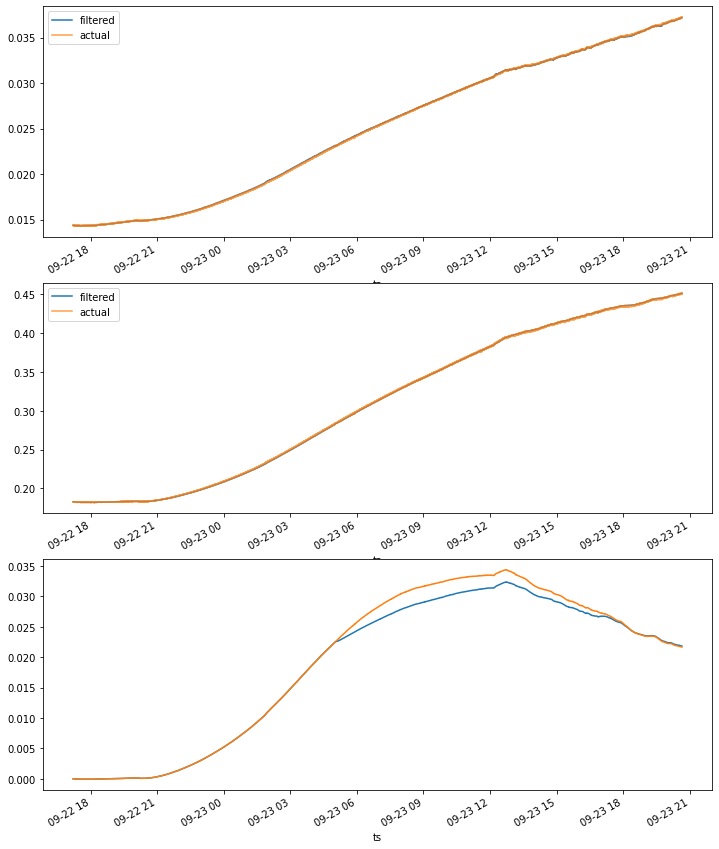

In [266]:
f, axes = plt.subplots(3, 1, figsize=(12, 16))


tampered_results['90'].plot(label="filtered", ax=axes[0])
df__['90'].plot(ax=axes[0], alpha=0.75, label="actual")
axes[0].legend()


tampered_results['135'].plot(label="filtered", ax=axes[1])
df__['135'].plot(ax=axes[1], alpha=0.75, label="actual")
axes[1].legend()

(np.log(tampered_results['rate']) *  60 * 60 * 0.2).plot(label="rate", ax=axes[2], x_compat=True)
(np.log(untampered_results['rate']) *  60 * 60 * 0.2).plot(label="rate", ax=axes[2], x_compat=True)

